# Классификация фильмов по сложности восприятия английского языка

Запрос сформирован тем, что просмотр фильмов на оригинальном языке это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.ч. студент понимал 50 - 70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат от преподавателя.

Цель этого проекта состоит в разработке ML решения для автоматического определения уровня сложности англоязычных фильмов. 

План работы:
1. Подготовка данных.
2. Анализ данных.
3. Построение модели машинного обучения.
4. Вывод.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pysrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

from catboost import CatBoostClassifier, Pool

In [2]:
# Загрузка модулей
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import textstat

In [4]:
pd.set_option('display.max_columns', None)

# Классификация фильмов по сложности восприятия английского языка

## 1. Подготовка данных. 

Работать с исходными данными будем работать в следующей последовательности:
1. Загрузим и проведём первичный анализ данных.
2. Произведём предобработку данных.
3. Сформируем датасет из файлов субтитров

### 1.1 Загрузка и первичный анализ данных


In [5]:
# Загрузим датасет
df = pd.read_csv('English_level/films_table.csv')
# Загрузим предварительно сформированные данные о сложности слов согласно Оксфордского словаря
df_words = pd.read_csv('Oxsford_dikt.csv')
# и списка идиом
df_idioms = pd.read_csv('English_level/theidioms_com.csv', sep='#')


In [6]:
df.head(10)

,name,level,subtitles,type,source,file
0,Forrest Gump,"A2/A2+, B1",Yes,movie,unknow,Forrest_Gump(1994).srt
1,Finding Nemo,A2/A2+,Yes,movie,unknow,Finding_Nemo(2003).srt
2,Cast away,A2/A2+,Yes,movie,unknow,Cast_away(2000).srt
3,The invisible man (2020),A2/A2+,Yes,movie,unknow,The_invisible_man(2020).srt
4,Back to the future,A2/A2+,Yes,movie,unknow,Back_to_the_future(1985).srt
5,Twilight,A2/A2+,Yes,movie,unknow,Twilight(2008).srt
6,Toy story,A2/A2+,Yes,movie,unknow,Toy_story(1995).srt
7,The cabin in the woods,A2/A2+,Yes,movie,unknow,The_cabin_in_the_woods(2012).srt
8,Up,A2/A2+,Yes,movie,unknow,Up(2009).srt
9,Dredd,A2/A2+,Yes,movie,unknow,Dredd(2012).srt


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       204 non-null    object
 1   level      204 non-null    object
 2   subtitles  204 non-null    object
 3   type       204 non-null    object
 4   source     204 non-null    object
 5   file       204 non-null    object
dtypes: object(6)
memory usage: 9.7+ KB


In [8]:
df['level'].value_counts()

B1            72
B2            71
A2/A2+        26
C1            14
B1, B2         8
A2/A2+, B1     5
A2             5
A1             2
C2             1
Name: level, dtype: int64

In [9]:
df[df['name'].duplicated()]

,name,level,subtitles,type,source,file
92,Sleepless in Seattle,B1,Yes,movie,unknow,Sleepless_in_Seattle(1993).srt


In [10]:
df[df['name'] == 'Sleepless in Seattle']

,name,level,subtitles,type,source,file
19,Sleepless in Seattle,A2/A2+,Yes,movie,unknow,Sleepless_in_Seattle(1993).srt
92,Sleepless in Seattle,B1,Yes,movie,unknow,Sleepless_in_Seattle(1993).srt


In [11]:
df.loc[[15, 86, 12, 93, 48, 90, 58, 102]]

,name,level,subtitles,type,source,file
15,Kubo and the two strings,A2/A2+,Yes,movie,unknow,Kubo_and_the_two_strings(2016).srt
86,Kubo and the Two Strings,B1,Yes,movie,unknow,Kubo_and_the_two_strings(2016).srt
12,The terminal,"A2/A2+, B1",Yes,movie,unknow,The_terminal(2004).srt
93,The Terminal,B1,Yes,movie,unknow,The_terminal(2004).srt
48,Inside out,B1,Yes,movie,unknow,Inside_out(2015).srt
90,Inside Out,B1,Yes,movie,unknow,Inside_out(2015).srt
58,The blind side,B1,Yes,movie,unknow,The_blind_side(2009).srt
102,The Blind Side,B2,Yes,movie,unknow,The_blind_side(2009).srt


In [12]:
df[df['name'] == 'The blind side']

,name,level,subtitles,type,source,file
58,The blind side,B1,Yes,movie,unknow,The_blind_side(2009).srt


In [13]:
df[df['name'] == 'The Blind Side']

,name,level,subtitles,type,source,file
102,The Blind Side,B2,Yes,movie,unknow,The_blind_side(2009).srt


**Вывод:**

В датасете содержится информация о 204-х фильмах.
Выявлены следующие проблемные вопросы:
1. Имеются дубликаты некоторых фильмов: "Sleepless in Seattle", "Kubo and the Two Strings", "The Terminal", "Inside Out". Причём, для некоторых дублирующихся фильмов указаны разные уровни сложности.
2. Для некоторых фильмов указаны уровни нескольких категорий:
    - `A2/A2+` преобразуем к `А2` так как категория А2+ не предусмотрена
    - `B1, B2` и `A2/A2+, B1` - малочислены, и поэтому мы их трогать пока не будем. Попробуем их классифицировать моделью обученной на классах которые определены.
3. Не ко всем фильмам есть субтитры.
4. Присутствует дисбаланс классов. Фильмов класса `A1` всего два, а `C2` только один.

### 1.2 Предобработка данных
1. Предобработка:
    - избавимся от дубликатов названий фильмов с преобразованием их уровней сложности.
    - Преобразуем класс `A2/A2+` к `А2`
2. Определим целевую переменную. Так-как тип `A1` и `C2` наименее представительны, объединим их с классами `A2` и `C1` соответственно. Кроме борьбы с дизбалансом и улучшения качества будущей модели, логика данного объединениея соответствует мнению экспертов в области изучения Английского языка. Оно заключается в том, что для изучающих язык, находящихся на уровне `A1` ещё рано изучать его с помощью просмотра фильмов. А для тех кто владеет языком на уровне `С2`, уже можно смотреть любой фильм.

In [14]:
# Удаляем дубликаты
df = df.drop([86, 90, 92, 93, 102, 173])
# Совмещаем классы удалённых дубликатов
df.loc[[15, 19, 58], 'level'] = ['A2/A2+, B1','A2/A2+, B1','B1, B2']

In [15]:
# Файл с субтитрами имеет не правильный формат
# df[df['file'] == 'inside-einsteins-mind-the-enigma-of-space-and-time.2015.varivoda_sp.srt']
# df = df.drop(173)


In [16]:
# Нет такого файла
df[df['file'] == 'Finch.2021.varivoda_sp.srt']

,name,level,subtitles,type,source,file
202,Finch (2021),A2,Yes,movie,https://magazine.skyeng.ru/6-novyh-filmov-dlja...,Finch.2021.varivoda_sp.srt


In [17]:
# Удалим
df = df.drop(202)

In [18]:
# Предобработка классов
df['level'] = df['level'].replace({'A2/A2+':'A2'})
df['level'].value_counts()

B2            70
B1            66
A2            28
C1            14
B1, B2         9
A2/A2+, B1     7
A1             2
C2             1
Name: level, dtype: int64

In [19]:
# Кодируем целевую переменную
targets = {
           'A1':2, 
           'A2':2,
           'B1':3,
           'B2':4,
           'C1':5,
           'C2':5,
           'B1, B2':0,
           'A2/A2+, B1':0
            }
df['target'] = df['level'].apply(lambda x: targets[x])

**Вывод:**

Произвели предварительную обработку данных и сформировали целевой признак.

### 1.3 Формирование набора данных из файлов субтитров.

Текст субтитров для каждого фильма находится в отдельном файле. Для более удобной обработки субтитров воспользуемся библиотекой `pysrt`. Кроме простого прочнения текста субтитров произведём их обработку и извлечение признаков.
1. Очистку от лишних символов и слов:
    - признаков начала и конца фраз
    - указателей цвета шрифта и фона
    - заголовков с именами говорящих
2. Обработку текста:
    - приведение всего текста к нижнему регистру
    - лемматезацию текста
    - удаление стоп-слов
3. Извлечение признаков:
    - текстовые: текст, лемматезированный текст, морфологические формы слов.
    - признаки на основе сложности слов,
    - признаки на основе библиотеки `textstat`: индекс удобочитаемости, уровень оценки Флеша-Кинкейда, индекс Коулмана-Лиау и тд.
    - темп речи, доля идиом, морфологическая сложность, среднее количество уникальных слов во фразе и т.д.
    

In [20]:
wnl = WordNetLemmatizer()

In [21]:
def sub_processing(filename):
    """ Принимаем имя файла субтитров
        Возвращаем список параметров расчитаных на основе обработки файла
    """
    # читаем файл субтитров
    try:
        subs = pysrt.open('English_level/Subtitles_all/' + filename)
    except:
        subs = pysrt.open('English_level/Subtitles_all/' + filename, encoding='ANSI')
        
    # Время начала фольма
    film_start = subs[0].start.hours*3600 + subs[0].start.minutes*60 + subs[0].start.seconds
    # Время окончания фильма
    if subs[-1].index - subs[-2].index < 2:
        film_end = subs[-1].end.hours*3600 + subs[-1].end.minutes*60 + subs[-1].end.seconds
    else:
        film_end = subs[-2].end.hours*3600 + subs[-2].end.minutes*60 + subs[-2].end.seconds\
    # Продолжительность фильма
    film_start, film_end = min(film_start, film_end), max(film_start, film_end)
    film_lenght = film_end - film_start
        
    # Очистка текста
    # text = re.sub('<i>|</i>', '', subs.text)
    text = re.sub('\<.*?\>', '', subs.text)      # удаляем то что в скобках <>
    text = re.sub('\n', ' ', text)               # удаляем разделители строк    
    # text = re.sub('<font.*?font>', '', text)
    text = re.sub('\(.*?\)', '', text)           # удаляем то что в скобках ()    
    text = re.sub('\[.*?\]', '', text)           # удаляем то что в скобках []
    text = re.sub('[A-Z]+?:', '', text)          # удаляем слова написанные заглавными буквами с двоеточием(это имена тех кто говорит)
    text = re.sub('\.+?:', '\.', text)           # Заменяем троеточия на одну точку
    text = text.lower()
    text = re.sub('[^a-z\.\!\?]', ' ', text)     # удаляем всё что не буквы и не .?!
    text = re.sub(' +', ' ', text)               # удаляем " +"
    # text = re.sub(r'\n ', '', text)
     
    # Количество предложений
    num_sentence = len(re.split('[\.\?\!]', text))
    
    # морфологический разбор
    morphs = [_[1] for _ in nltk.pos_tag(re.sub('\n', ' ', text).lower().split(' '))]
    # Герундий
    gerund = morphs.count('VBG')
    
    text_no_preproc = text
    text = re.sub('[^a-z]', ' ', text)     # удаляем всё что не буквы
    
    # ищем идиомы
    num_idioms = 0
    for idiom in df_idioms['lem_idiom']:
        match = re.finditer(fr'{idiom}', text)
        num_idioms += len([_ for _ in match])
    
    # Количество символов
    text_len = len(text)
    # Букв в секунду
    sumb_persecond = text_len / film_lenght
    
    # # Избавимся от стоп-слов
    # for stop_word in nltk_stopwords.words('english'):
    #     text = re.sub(f' {stop_word} ', ' ', text)
        
    # удалим однобуквенные слова
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    text = re.sub(' [a-z] ', ' ', text)
    
    text_no_lem = text
    
     # Список уникальных слов
    words = text.split(' ')
    words_unique = []
    for word in words:
        if word not in words_unique:
            words_unique.append(word)
    
    sumb_perword = (text_len - len(words)) / len(words)
        
    # Расчитаем количество слов разной сложности в фильме 
    difficulty = {'A1':0,
                  'A2':0,
                  'B1':0,
                  'B2':0,
                  'C1':0,
                 }
    
    for word in words_unique:
        match = df_words[df_words['word'] == word]['diff'].values
        if len(match) > 0:
            for dif in match:
                difficulty[dif] += 1
       
    # Лемматизация
    text = ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in text.split(' ')])
    
    # Посчитаем продолжительность всех фраз
    phrases_lenght = 0
    for sub in subs:
         # Время начала фразы
        phrase_start = sub.start.hours*3600 + sub.start.minutes*60 + sub.start.seconds
        # Время окончания фразы
        phrase_end = sub.end.hours*3600 + sub.end.minutes*60 + sub.end.seconds
        # Продолжительность фразы
        phrases_lenght += max(0, phrase_end - phrase_start)
    
    sumb_persecond_frases = text_len / phrases_lenght
    
    # Возвращаем результаты
    return [film_lenght,
            text_len, 
            len(text),
            sumb_persecond, 
            phrases_lenght,
            sumb_persecond_frases,
            sumb_perword,
            max(num_sentence, len(subs)),
            len(words) / max(num_sentence, len(subs)),
            difficulty['A1']/len(words_unique),
            difficulty['A2']/len(words_unique),
            difficulty['B1']/len(words_unique),
            difficulty['B2']/len(words_unique),
            difficulty['C1']/len(words_unique),
            len(subs),
            len(words_unique) / len(subs),
            len(words),
            len(words_unique),
            len(words_unique) / film_lenght,
            len(words_unique) / len(words),
            textstat.flesch_reading_ease(text_no_preproc),
            textstat.flesch_kincaid_grade(text_no_preproc),
            textstat.smog_index(text_no_preproc),
            textstat.coleman_liau_index(text_no_preproc),
            textstat.automated_readability_index(text_no_preproc),
            textstat.dale_chall_readability_score(text_no_preproc),
            textstat.difficult_words(text_no_preproc),
            textstat.linsear_write_formula(text_no_preproc),
            textstat.gunning_fog(text_no_preproc),
            textstat.text_standard(text_no_preproc),
            textstat.fernandez_huerta(text_no_preproc),
            textstat.szigriszt_pazos(text_no_preproc),
            textstat.gutierrez_polini(text_no_preproc),
            textstat.crawford(text_no_preproc),
            textstat.gulpease_index(text_no_preproc),
            textstat.osman(text_no_preproc),
            num_idioms,
            gerund,
            gerund / num_sentence, 
            text,
            text_no_lem,
            ' '.join(morphs)
           ]

In [22]:
%%time
new_columns = ['film_lenght', 
               'text_len', 
               'lematise_text_len', 
               'sumb_persecond',
               'phrases_lenght',
               'sumb_persecond_frases',
               'sumb_perword',
               'num_sentence',
               'word_persentence',
               'A1',
               'A2',
               'B1',
               'B2',
               'C1',
               'phrases_count',
               'words_unique_perphrase', 
               'words_count',
               'words_unique_count',
               'words_unique_persecond',
               'lexical_diversity',
               'flesch_reading_ease',
               'flesch_kincaid_grade',
               'smog_index',
               'coleman_liau_index',
               'automated_readability_index',
               'dale_chall_readability_score',
               'difficult_words',
               'linsear_write_formula',
               'gunning_fog',
               'text_standard',
               'fernandez_huerta',
               'szigriszt_pazos',
               'gutierrez_polini',
               'crawford',
               'gulpease_index',
               'osman',
               'num_idioms',
                'gerund',
                'gerund_persentence', 
               'text',
               'text_no_lem',
               'morphs'
              ]

df.loc[~df['file'].isna(), new_columns] = [_ for _ in df.loc[~df['file'].isna(), 'file'].apply(sub_processing)]
df.head()

CPU times: total: 4min 42s
Wall time: 4min 47s


,name,level,subtitles,type,source,file,target,film_lenght,text_len,lematise_text_len,sumb_persecond,phrases_lenght,sumb_persecond_frases,sumb_perword,num_sentence,word_persentence,A1,A2,B1,B2,C1,phrases_count,words_unique_perphrase,words_count,words_unique_count,words_unique_persecond,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,text_standard,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford,gulpease_index,osman,num_idioms,gerund,gerund_persentence,text,text_no_lem,morphs
0,Forrest Gump,"A2/A2+, B1",Yes,movie,unknow,Forrest_Gump(1994).srt,0,7841.0,57944.0,53972.0,7.389874,4247.0,13.643513,3.661250,1800.0,6.906111,0.298750,0.168750,0.094375,0.082500,0.026875,1547.0,1.034260,12431.0,1600.0,0.204056,0.128710,95.98,2.2,6.1,2.75,1.6,5.12,449.0,4.100000,4.18,4th and 5th grade,125.46,122.39,55.50,0.3,82.4,96.62,74.0,203.0,0.112778,hello my name forrest forrest gump do you w...,hello my name forrest forrest gump do you w...,NN PRP$ NN JJ NN JJS NN VBP PRP VB DT NN NN MD...
1,Finding Nemo,A2,Yes,movie,unknow,Finding_Nemo(2003).srt,2,6102.0,54231.0,50739.0,8.887414,4961.0,10.931465,3.194848,3459.0,3.737496,0.234229,0.120327,0.071262,0.072430,0.029790,2198.0,0.778890,12928.0,1712.0,0.280564,0.132426,99.02,1.0,5.9,1.33,0.9,5.49,589.0,2.750000,3.15,0th and 1st grade,128.52,125.17,56.48,-0.9,96.8,99.43,79.0,133.0,0.038450,advertise your product or brand herecontact w...,advertise your product or brand herecontact w...,JJ VB PRP$ NN CC NN NN NN NN VBP NN NN NN NN J...
2,Cast away,A2,Yes,movie,unknow,Cast_away(2000).srt,2,8129.0,24711.0,23113.0,3.039857,2022.0,12.221068,3.294578,1303.0,4.415963,0.365900,0.174330,0.086207,0.088123,0.027778,777.0,1.343629,5754.0,1044.0,0.128429,0.181439,98.31,1.3,5.8,1.57,0.8,5.43,267.0,3.833333,3.47,0th and 1st grade,127.80,125.64,56.75,-0.6,92.7,100.36,55.0,47.0,0.036071,create and encode by bokutox of www yify torre...,created and encoded by bokutox of www yify tor...,VBN CC VBN IN NN IN NN IN DT JJS NN NN NN NNS ...
3,The invisible man (2020),A2,Yes,movie,unknow,The_invisible_man(2020).srt,2,6576.0,25802.0,23778.0,3.923662,1762.0,14.643587,3.344502,1174.0,5.058773,0.385593,0.191737,0.105932,0.097458,0.025424,866.0,1.090069,5939.0,944.0,0.143552,0.158949,97.30,1.7,6.0,1.12,0.4,5.20,257.0,1.700000,3.93,1st and 2nd grade,126.78,125.09,57.73,-0.3,88.9,102.73,32.0,97.0,0.082624,adrian come on zeus sorry can take you with...,adrian come on zeus sorry can take you with...,JJ VB IN NN NN VBP NN NN MD VB VB PRP IN NN NN...
4,Back to the future,A2,Yes,movie,unknow,Back_to_the_future(1985).srt,2,6602.0,48171.0,45308.0,7.296425,3251.0,14.817287,3.638070,1880.0,5.524468,0.256827,0.153399,0.079024,0.076119,0.030215,1529.0,1.125572,10386.0,1721.0,0.260679,0.165704,97.60,1.5,6.5,3.09,1.8,5.69,662.0,8.285714,4.19,1st and 2nd grade,127.09,121.83,54.55,-0.1,87.3,94.10,82.0,163.0,0.086702,october be inventory time so right now statler...,october is inventory time so right now statler...,NN VBZ JJ NN RB RB RB VB NN VBZ VBG DT JJS NNS...


In [23]:
# И ещё немного признаков

df['avg_dificulty'] = df[['A1','A2','B1','B2','C1']].apply(lambda x: np.mean([x['A1'], x['A2']*1.5, x['B1']*5, x['B2']*50, x['C1']*500]) ,axis=1)
df['idioms_persentence'] = df['num_idioms'] / df['num_sentence'] 

**Вывод:** Файлы субтитров обработаны. Извлечены признаки из текста субтитров.

**Вывод**

На первом этапе была произведена загрузка исходного датасета и сформирован итоговый датасет на основе данных из файлов субтитров. Извлечены признаки необходимые для построения модели машинного обучения.

## 2. Анализ данных

В данном разделе проанализируем полученные признаки, и попробуем понять чем отличаются фильмы разной сложности.

1. Сформируем сводную таблицу по уровням фильмов со средними значениями всех параметров.
2. Построим парные графики с разделением по уровню фоильмов.
3. Построим корреляционную матрицу с целью выявления корреляционных зависимостей.

In [24]:
pivot_table = df[df['level'].isin(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])].groupby('level').mean()
pivot_table

,target,film_lenght,text_len,lematise_text_len,sumb_persecond,phrases_lenght,sumb_persecond_frases,sumb_perword,num_sentence,word_persentence,A1,A2,B1,B2,C1,phrases_count,words_unique_perphrase,words_count,words_unique_count,words_unique_persecond,lexical_diversity,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,difficult_words,linsear_write_formula,gunning_fog,fernandez_huerta,szigriszt_pazos,gutierrez_polini,crawford,gulpease_index,osman,num_idioms,gerund,gerund_persentence,avg_dificulty,idioms_persentence
level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1,2.0,9435.500000,44043.500000,40412.500000,5.233864,6443.500000,10.033514,3.849823,2388.000000,4.377611,0.385568,0.159130,0.077287,0.080783,0.027863,2226.500000,0.738648,9174.500000,1221.000000,0.156666,0.126141,-534.830000,245.600000,12.950000,2.665000,312.850000,34.245000,355.500000,32.000000,254.420000,-509.710000,-500.285000,-160.865000,0.950000,72.000000,-530.820000,59.500000,164.000000,13.682384,3.796285,0.029490
A2,2.0,6156.464286,40220.464286,37596.678571,6.620002,3320.321429,12.237589,3.437522,1803.321429,5.065840,0.317433,0.164601,0.093458,0.087429,0.032311,1379.464286,1.024108,9078.357143,1326.071429,0.219716,0.153549,84.376429,6.403571,6.589286,1.935357,6.907143,5.777857,380.642857,8.449692,8.537500,114.066429,112.673929,52.306429,-0.267857,88.257143,87.330000,59.928571,114.607143,0.319249,4.311747,0.033300
B1,3.0,6176.212121,45436.227273,42303.833333,7.368669,3455.757576,13.127780,3.457158,1981.348485,5.295151,0.313729,0.164681,0.098104,0.092093,0.033056,1399.590909,1.082418,10207.833333,1467.909091,0.239724,0.149428,96.892879,1.680303,6.121212,1.817424,0.909091,5.297424,446.484848,5.629213,3.812121,126.528333,124.178333,56.532424,-0.289394,89.284848,99.537879,68.621212,131.287879,0.070727,4.436775,0.036414
B2,4.0,6568.828571,48109.985714,44934.300000,7.428933,3656.214286,13.148053,3.483579,2055.885714,5.279028,0.297576,0.163926,0.098164,0.095016,0.037005,1481.514286,1.066659,10705.371429,1534.485714,0.239813,0.149937,77.867143,8.790000,6.748571,2.285429,10.175714,6.193714,503.071429,6.199188,11.086143,107.649286,105.379000,49.642286,-0.140000,87.414286,79.547286,70.214286,143.328571,0.383800,4.857499,0.034113
C1,5.0,6171.214286,48188.142857,45166.000000,7.967917,3575.928571,13.229827,3.612947,2075.071429,5.234952,0.287574,0.165172,0.100467,0.099545,0.037607,1461.785714,1.103217,10470.214286,1593.714286,0.265671,0.161997,57.086429,16.214286,8.550000,3.176429,19.564286,7.251429,551.071429,6.818714,18.467857,87.447143,85.938571,42.457143,0.250000,82.664286,58.731429,69.000000,157.357143,0.760804,4.963694,0.033498
C2,5.0,7528.000000,20497.000000,19416.000000,2.722768,1726.000000,11.875435,3.282700,895.000000,5.347486,0.356069,0.163006,0.106358,0.086705,0.039306,829.000000,1.043426,4786.000000,865.000000,0.114904,0.180735,105.760000,0.500000,5.000000,1.460000,0.700000,5.240000,138.000000,3.818182,3.420000,132.780000,128.980000,57.130000,-0.600000,88.400000,101.580000,15.000000,35.000000,0.039106,5.024162,0.016760


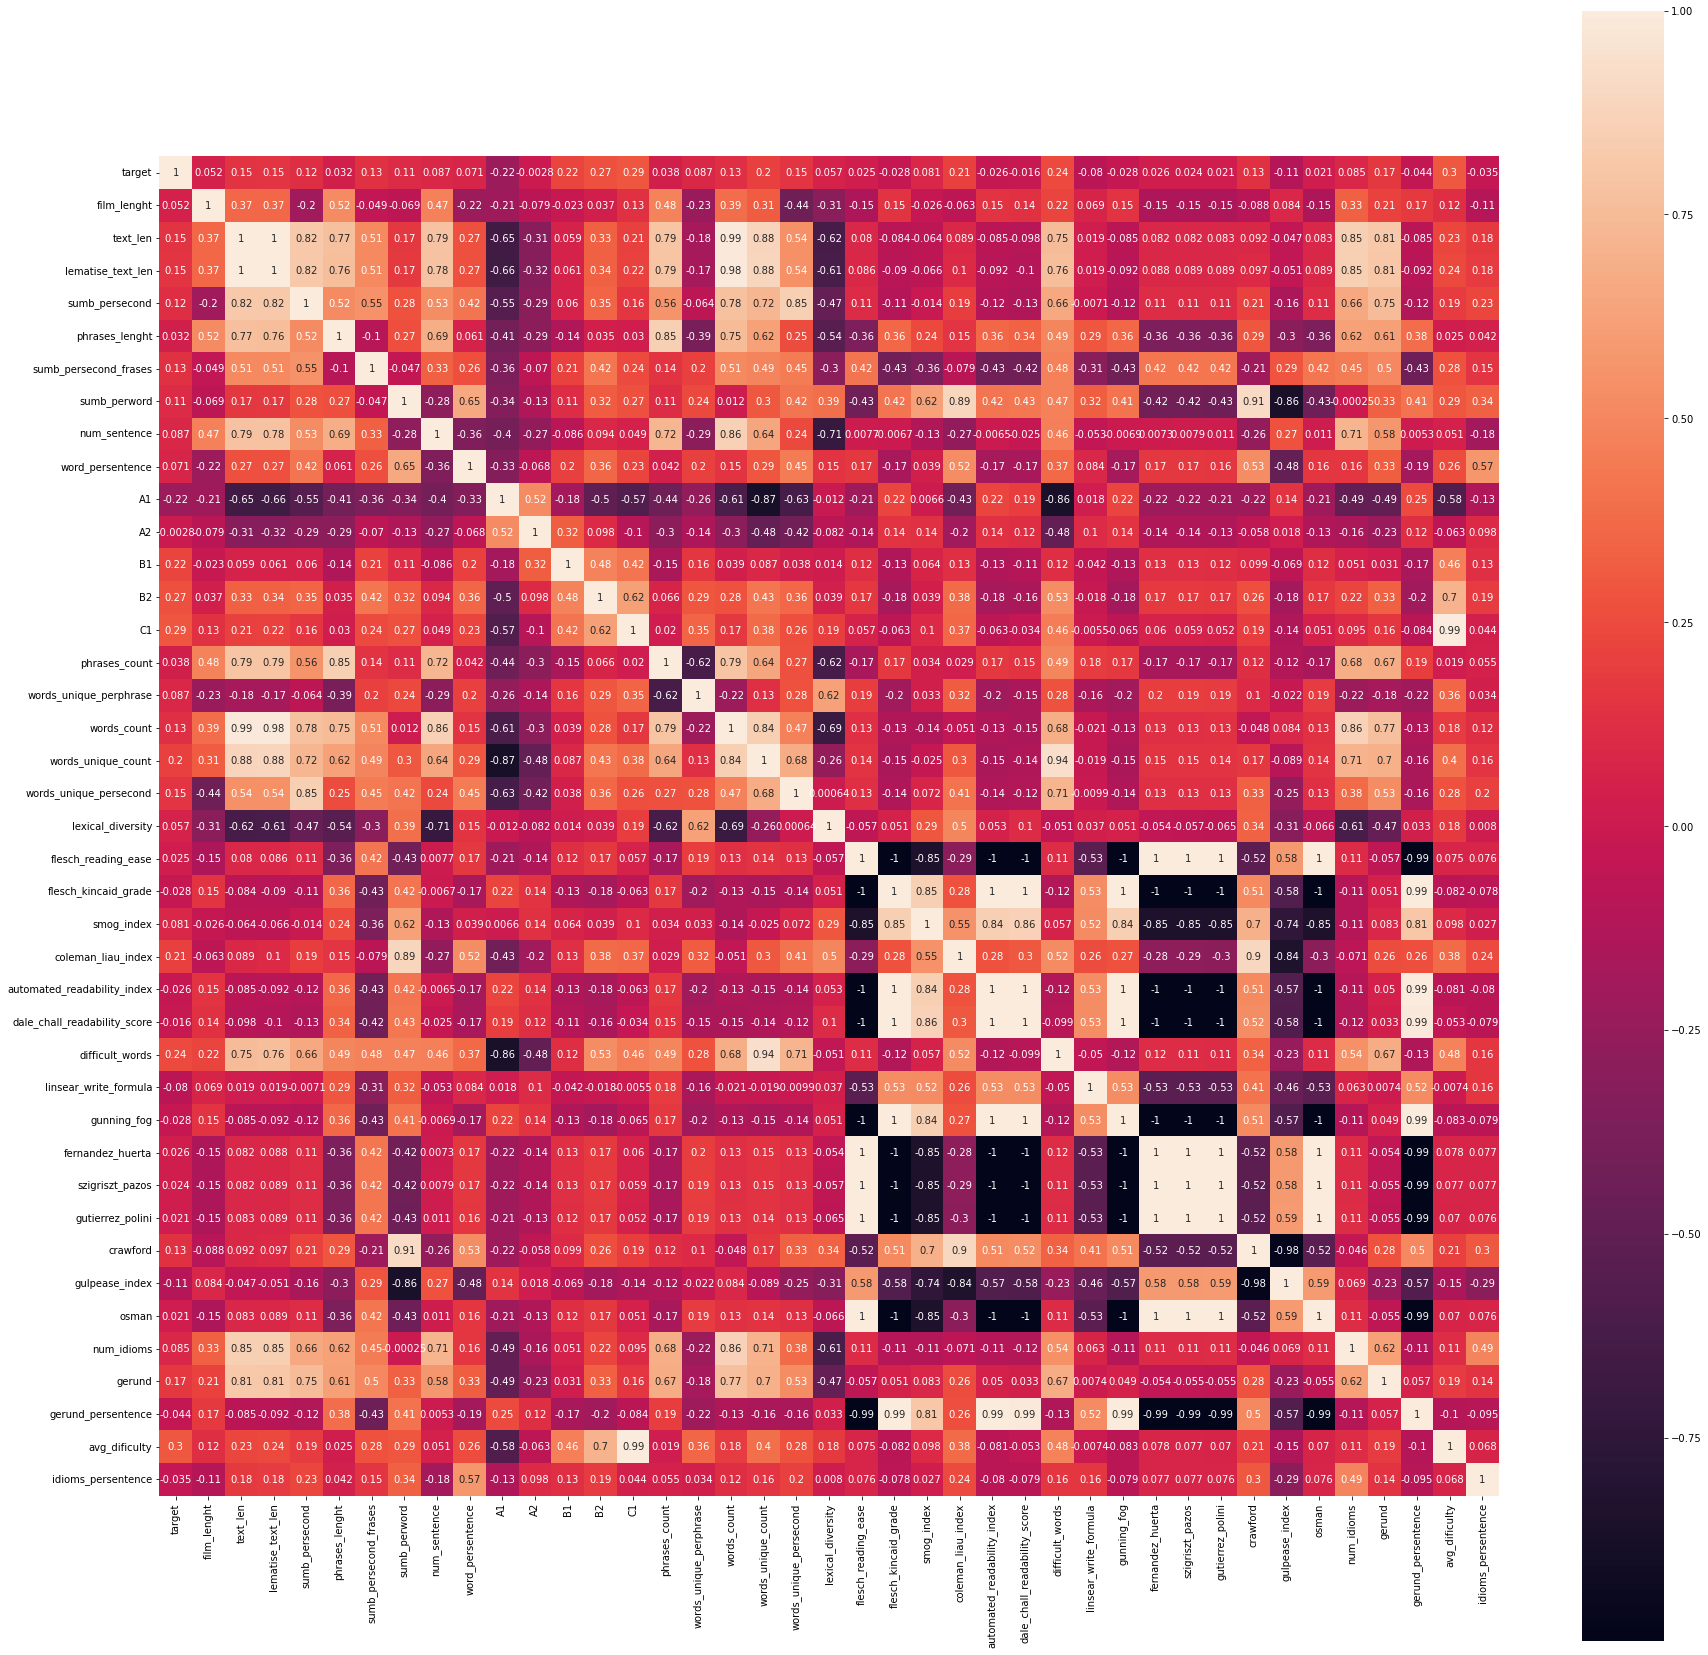

In [25]:
plt.rcParams['figure.figsize']=(30,30)
sns.heatmap(df[df['target'] != 0].corr(), square=True, annot=True);

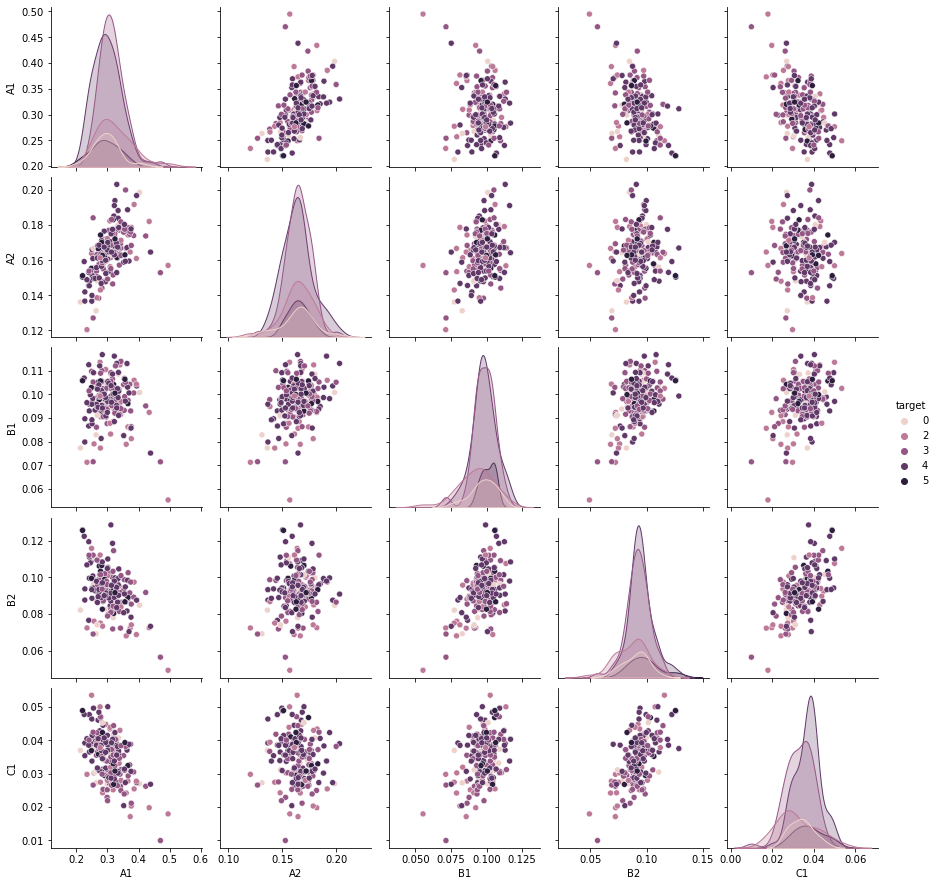

In [26]:
sns.pairplot(data=df[['A1','A2','B1','B2','C1','target']], hue='target');

**Вывод:** 
1. Исходя из анализа построенной корреляционной матрицы, можно сделать следующие выводы:
    - Целевой признак не имеет сильной корреляционной зависимости от какого-либо признака.
    - Примерно половина признаков имеют сильные корреляционные зависимости друг с другом
2. На построенных парных графиках также невидно возможности чётко разделить объекты по целевому признаку.

Таким образом, на данном этапе невозможно выделить признаки наиболее чётко ввделяющие один класс от другого. Можно лишь избавться от от признаков сильно коррелирующих друг с другом.

## 3 Построение модели машинного обучения

Для решения поставленной задачи были применены разные модели машинного обучения, разные наборы признаков и разные подходы к кодированию текстовой информации.
Я не буду приводить здесь все варианты решений, а остановлюсь только на том, который показал наибольшую эффективность:
1. Модель: CatBoostClassifier
2. Набор признаков:
    - `phrases_lenght` - средняя длина фразы
    - `A2` - доля уникальных слов сложности `A2` 
    - `coleman_liau_index` - уровень качества текста по формуле Коулмана-Лиау
    - `word_persentence` - среднее количество слов во фразе
    - `gulpease_index` - индекс текста Gulpease(вообще он для итальянского текста, но подошел и к английскому)
    - `gerund_persentence` - среднее количество герундия во фразе
    - `words_unique_perphrase` - среднее количество уникальных слов во фразе
    - `words_unique_persecond` - среднее количество уникальных слов в секунду
    - `morphs` - морфологические формы слов
    - `avg_dificulty` - средняя сложность слов
    - `idioms_persentence` - среднее количество идиом во фразе
3. Кодировка текста производилась внутренним алгоритмом модели CatBoostClassifier. А в качестве текста выступали морфологические формы слов.

### 3.1 Подготовка выборок

1. Разделим датасет на тренировочную, валидационную и тестовую выборки.
2. Обучим модель и подберём гиперпараметры
3. Протестируем модель

In [27]:
efectiv_features =[
        'name',
        'phrases_lenght', 
        'A2', 
        'coleman_liau_index', 
        'word_persentence', 
        'gulpease_index', 
        'gerund_persentence', 
        'words_unique_perphrase', 
        'words_unique_persecond',
        'morphs',
        'target',
        'avg_dificulty',
        'idioms_persentence',
]

In [28]:
features = df[efectiv_features].set_index('name').dropna().copy()
features = features[features['target'] != 0]

X = features.drop(columns=['target'])
y = features['target']

# Разделим на выборки
X_train, X_tv, y_train, y_tv = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_tv, y_tv, test_size=0.5, random_state=42)

In [29]:
# Проверим размеры выборок
pd.DataFrame({'X_train':[X_train.shape[0], X_train.shape[1]],
              'y_train':[y_train.shape[0], 1],
              'X_valid':[X_valid.shape[0], X_valid.shape[1]],
              'y_valid':[y_valid.shape[0], 1],
              'X_test':[X_test.shape[0], X_test.shape[1]],
              'y_test':[y_test.shape[0], 1],
             },
              index=['index','columns']
            )

,X_train,y_train,X_valid,y_valid,X_test,y_test
index,108,108,36,36,37,37
columns,11,1,11,1,11,1


In [30]:
# Для модели CatBoostClassifier сформируем пулы
# Тренировочный пул
train_pool = Pool(data=X_train,
                  label=y_train,
                  text_features=['morphs'],
                 )
# Валидационный пул
valid_pool = Pool(data=X_valid,
                   label=y_valid,
                   text_features=['morphs'],
                  )
# Тестовый пул
test_pool = Pool(data=X_test,
                   label=y_test,
                   text_features=['morphs'],
                  )

# Тренировочный + Валидационный пул
learn_pool = Pool(data=pd.concat([X_train, X_valid]),
                  label=pd.concat([y_train, y_valid]),
                  text_features=['morphs'],
                 )

**Вывод:** Данные готовы для обучения модели

### 3.2 Построение модели машинного обучения

Так как датасет имеет совсем небольшой размер, модель градиентного бустинга очень легко переобучается. Поэтому было решено в качестве индикатора переобучения использовать валидационную выборку.

In [31]:
def fit_model(train_pool, valid_pool, **kwargs):
    """ Принимаем тренировочный и тестовый пул, а также параметры модели.
        Возвращаем обученную модель
    """
    model = CatBoostClassifier(
                               eval_metric='Accuracy',
                               od_type='Iter',
                               od_wait=500,
                               tokenizers=
                                     [{'tokenizer_id': 'Sense',
                                       'separator_type': 'BySense',
                                       'lowercasing': 'True',
                                       'token_types':['Word', 'Number', 'SentenceBreak'],
                                       'sub_tokens_policy':'SeveralTokens'
                                      }],
                                     dictionaries = [{'dictionary_id': 'Word','max_dictionary_size': '1000'}],
                                     feature_calcers = ['BoW:top_tokens_count=1000'],
                               **kwargs
                              )
    return model.fit(train_pool,
                     eval_set=valid_pool,
                     verbose=100,
                     plot=True,
                     use_best_model=True)

In [32]:
%%time
# Обучаем модель
model = fit_model(train_pool,
                  valid_pool,
                  iterations=1000,
                  learning_rate=0.13,
                  max_depth=6,
                  # l2_leaf_reg=2,
                )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5555556	test: 0.4166667	best: 0.4166667 (0)	total: 136ms	remaining: 2m 15s
100:	learn: 1.0000000	test: 0.3611111	best: 0.5277778 (18)	total: 480ms	remaining: 4.28s
200:	learn: 1.0000000	test: 0.3333333	best: 0.5277778 (18)	total: 1.04s	remaining: 4.14s
300:	learn: 1.0000000	test: 0.3611111	best: 0.5277778 (18)	total: 1.39s	remaining: 3.22s
400:	learn: 1.0000000	test: 0.3611111	best: 0.5277778 (18)	total: 1.75s	remaining: 2.61s
500:	learn: 1.0000000	test: 0.3888889	best: 0.5277778 (18)	total: 2.11s	remaining: 2.1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.5277777778
bestIteration = 18

Shrink model to first 19 iterations.
CPU times: total: 11.9 s
Wall time: 2.86 s


In [33]:
preds = model.predict(valid_pool)
accuracy_score(preds, y_valid)

0.5277777777777778

**Вывод:** Результат работы модели не получился слишком точным.

### 3.3 Тестирование модели

1. Протестируем модель на тестовой выборке и сохраним обученную модель для дальнейшего использования в скрипте микросервиса.
2. Сравним работу модели с фиктивной моделью.
3. Оценим важность признаков

In [34]:
preds = model.predict(test_pool)
accuracy_score(preds, y_test)

0.5405405405405406

In [35]:
%%time
# Обучаем модель
model = fit_model(learn_pool,
                  test_pool,
                  iterations=1000,
                  learning_rate=0.12,
                  # max_depth=6,
                  # l2_leaf_reg=1,
                 )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4305556	test: 0.4054054	best: 0.4054054 (0)	total: 1.38ms	remaining: 1.38s
100:	learn: 0.9791667	test: 0.6216216	best: 0.6486486 (58)	total: 924ms	remaining: 8.22s
200:	learn: 1.0000000	test: 0.5945946	best: 0.6486486 (58)	total: 1.91s	remaining: 7.59s
300:	learn: 1.0000000	test: 0.5945946	best: 0.6486486 (58)	total: 2.93s	remaining: 6.8s
400:	learn: 1.0000000	test: 0.5945946	best: 0.6486486 (58)	total: 4s	remaining: 5.97s
500:	learn: 1.0000000	test: 0.5945946	best: 0.6486486 (58)	total: 4.97s	remaining: 4.95s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6486486486
bestIteration = 58

Shrink model to first 59 iterations.
CPU times: total: 19.3 s
Wall time: 6.4 s


In [36]:
# Сохраним обученную модель для дальнейшего использования
model.save_model('catboostclassifier_model.cbm')

**Вывод:** Работа модели на тестовой выборке показала точность 0.54. Модель для продакшена была обучена на тренировочной + валидационной выборках, а в качестве индикатора переобучения использована тестовая выборка. При этом точность модели была оценена 0.65.

### Фиктивная модель

Для понимания как наша модель работает по отношению к фиктивной модели, которая будет работать по стратегии "most friqued", рассчитаем точность такой модели.

In [37]:
clases = y.value_counts()
clases

4    70
3    66
2    30
5    15
Name: target, dtype: int64

In [38]:
clases.max() /  clases.sum()

0.3867403314917127

**Вывод:** Тосчность фиктивной модели примерно в два раза ниже, чем наша обученная модель.

### 3.4 Оценка важности признаков

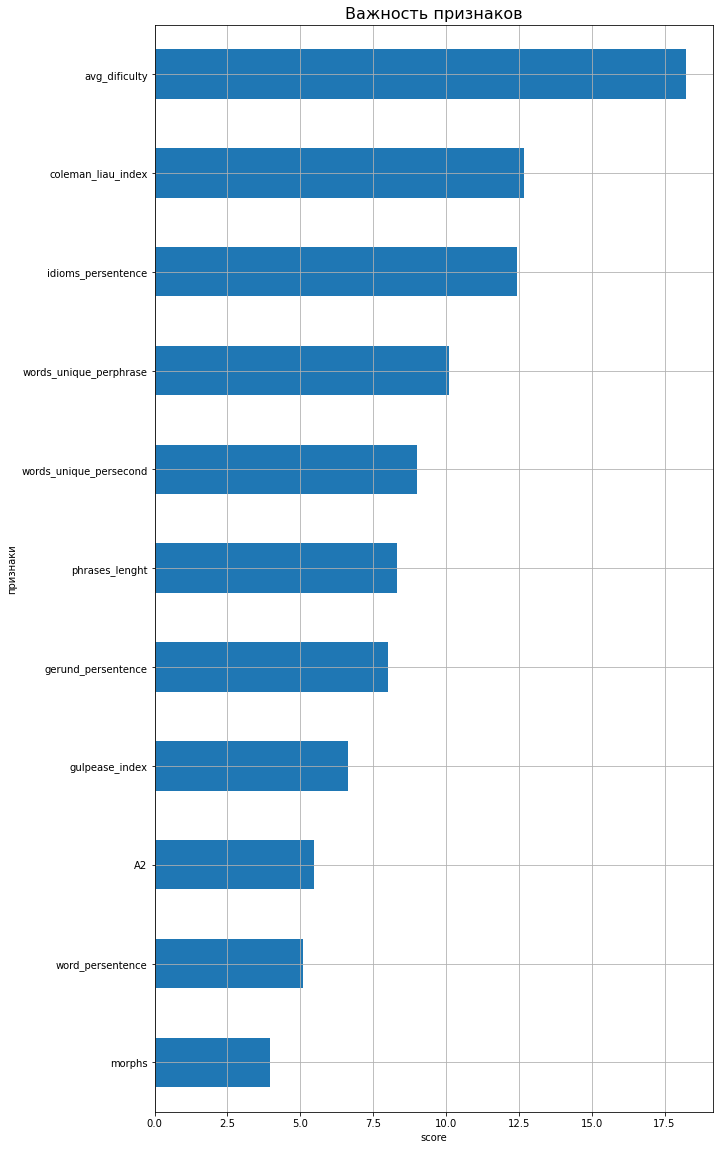

In [39]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': model.feature_importances_}, 
                            index=X_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** 
На графике видно, что наибольшую важност имеют признаки:
- `avg_dificulty` - средняя сложность слов
- `coleman_liau_index` - уровень качества текста по формуле Коулмана-Лиау
- `idioms_persentence` - среднее количество идиом во фразе


**Вывод**

Модель обучена и протестирована. Заданного порога качества задано небыло, а потому считаю, что качество в 1.7 раза больше фиктивной модели - вполне приемлемый результат.


## Вывод


На этапе подготовки данных была выполнена загрущка и первичный анализ данных, предобработка исходного датасета и формирования признакового пространства из информации находящийся в файлах субтитров. Для этого были использованы возможности библиотек pysrt, nltk и texstat. За рамками данной тетрадки остался процесс парсинга Оксфордского словаря сложности слов и составление словаря идиом. Также, файлы субтитров и сложность фильмов по классификации CEFR были внесены в датасет по результатам поиска в открытых источниках.

На этапе анализа данных были выявлены сильные корреляционные зависимости между большой частью признаков, но небыло выявлено корреляции признаков с целевой переменной. Это делало работу модели давольно не простой задачей.

Для построения модели машинного обучения из большого числа вариантов кодирования, извлечения признаков и типов моделей машинного обучения был выбран наиболее эффективный. На тестовой выборке удалось достичь метрики качества accuracy = 0.65. Это в 1.7 раза лучше чем показывает фиктивная модель.

Факторы мешающие достижению большего качества, на мой взгляд, следующие:
1. Размер датасета очень небольшой. Попытки его увеличить путём генерации новых объектов к увеличению качества модели не привели.
2. Субъективность оценок уровня фильмов. В разных источниках один и тот-же фильм мог иметь различный оценочный уровень. Отсюда и такие слабые различия между фильмами разных уровней.

Увеличение качества классификации может быть достигнуто устранением вышеуказанных факторов.